In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
from pathlib import Path		

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [1]:
df = pd.read_csv(r'data/merged_date_v2.csv', parse_dates = ['count_date'])
df.sort_values(by = "count_date", inplace = True)
df.head()
df.tail()

NameError: name 'pd' is not defined

In [5]:
import re
def add_datepart(df, fldname, drop=False, time=False, errors="raise"):	

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Dayofweek', 'Dayofyear', 'Year', 'Month']
#     , 'Week', 'Day',
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [6]:
# add date parts
# df.reset_index(inplace = True)
add_datepart(df, 'count_date')

In [7]:
df['road_name_code'] = df[['latitude', 'longitude']].astype('str').apply("_".join, 1)
df['road_name_code'] = df['road_name_code'].astype('category').cat.codes.astype('category')

In [8]:
df['road_name_code'].unique()

[5406, 5707, 5063, 5983, 5427, ..., 13290, 7309, 11183, 5891, 653]
Length: 13774
Categories (13774, int64): [5406, 5707, 5063, 5983, ..., 7309, 11183, 5891, 653]

In [9]:
df.columns

Index(['count_date', 'road_name', 'adt', 'latitude', 'longitude',
       'sampling_count', 'count_Dayofweek', 'count_Dayofyear', 'count_Year',
       'count_Month', 'count_Elapsed', 'road_name_code'],
      dtype='object')

In [10]:
df.head()
df.info()

,count_date,road_name,adt,latitude,longitude,sampling_count,count_Dayofweek,count_Dayofyear,count_Year,count_Month,count_Elapsed,road_name_code
0,1974-07-12,COLWILL RD,125.0,-36.832191,174.636777,3,4,193,1974,7,142819200,5406
10,1974-08-11,YEOVIL RD,2025.0,-36.844243,174.651030,7,6,223,1974,8,145411200,5707
8,1974-08-11,HOBSONVILLE RD,3900.0,-36.818111,174.615714,20,6,223,1974,8,145411200,5063
7,1974-08-11,KOTUKU ST,1700.0,-36.850907,174.648874,5,6,223,1974,8,145411200,5983
6,1974-08-11,TE ATATU RD,3733.0,-36.832667,174.648011,11,6,223,1974,8,145411200,5427


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20764 entries, 0 to 20763
Data columns (total 12 columns):
count_date         20764 non-null datetime64[ns]
road_name          20764 non-null object
adt                20764 non-null float64
latitude           20764 non-null float64
longitude          20764 non-null float64
sampling_count     20764 non-null int64
count_Dayofweek    20764 non-null int64
count_Dayofyear    20764 non-null int64
count_Year         20764 non-null int64
count_Month        20764 non-null int64
count_Elapsed      20764 non-null int64
road_name_code     20764 non-null category
dtypes: category(1), datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 2.7+ MB


In [11]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
ycol = 'adt'

In [12]:
# train test split
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import math

In [13]:
def rmse(x,y): 
    # calculates r^2
    return math.sqrt(np.square(np.subtract(x,y)).mean())
def get_scores(m, X_train, X_valid, y_train, y_valid):
    # returns rmsq training, r^2 validation, avg accuracy training, avg accuracy validation, oob
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    return res

def KFold_fit_regression_fit(model, X, y, splits = 5, repeats = 10, random_state = None):
    folds = RepeatedKFold(n_splits = splits, n_repeats = repeats, random_state = random_state)
#     predicted_solution = []
#     correct_solution = []
    results = []
    for train_ind, test_ind in folds.split(X, y):
        X_train, X_test = X.iloc[train_ind,:], X.iloc[test_ind,:]
        y_train, y_test = y[train_ind], y[test_ind]
        model.fit(X_train, y_train)
        r = get_scores(model,X_train, X_test, y_train, y_test)
#         predicted_solution += list(model.predict(X_test))
#         correct_solution += list(y_test)
        results.append(r)
    return np.vstack(results)


# Use oob for model selection and parameter tuning

In [14]:
# def functions for training
from sklearn.utils import shuffle
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test

def tt_split_by_years(df, xcols, ycol, train_years = [2016, 2017, 2018], test_years = [2019]):
#     df_model = df.copy()
#     X, y = df_model[xcols], df_model[ycol]
    df_train = df[df.count_Year.isin(train_years)]
    df_test = df[df.count_Year.isin(test_years)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 3):
#     d = datetime.fromtimestamp(selected_date_value)
    d = pd.to_datetime(split_date)
    train_lb = d - relativedelta(months = train_months)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[(df.count_date >= train_lb)&(df.count_date < d)]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [15]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
xcols.remove('count_date')
ycol = 'adt'

In [16]:
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2017-12-31', train_months = 48, test_months = 3)
m = RandomForestRegressor(n_estimators=500, max_depth=None, max_features=0.9, oob_score= True, random_state=1, n_jobs  = 3)
m.fit(X_train, y_train)
m.score(X_train, y_train)
m.score(X_test, y_test)
m.oob_score_
rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9503534642948323

0.04416444739409575

0.6365296839327668

,cols,imp
1,longitude,0.341168
8,road_name_code,0.165772
0,latitude,0.163246
7,count_Elapsed,0.116844
4,count_Dayofyear,0.099104
2,sampling_count,0.048198
3,count_Dayofweek,0.037568
6,count_Month,0.019782
5,count_Year,0.008317


road_name_code is importance suggesting historical adt is useful

## Try xgboost 

In [46]:
# # from xgboost import XGBRegressor
# import xgboost as xgb
# from sklearn.metrics import r2_score

In [51]:
# # xgboost cannot handle categorical features
# xgb_cols = xcols
# xgb_cols.remove('road_name_code')
# xgb_cols

['latitude',
 'longitude',
 'sampling_count',
 'count_Dayofweek',
 'count_Dayofyear',
 'count_Year',
 'count_Month',
 'count_Elapsed']

In [52]:
# X_train, X_test, y_train, y_test = tt_split_by_years(df, xgb_cols, ycol)
# m = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.01,
#                 max_depth = 50, n_estimators = 1000, subsample=.66)  # alpha = 10
# m.fit(X_train, y_train, early_stopping_rounds=5, 
#              eval_set=[(X_test, y_test)],
#              verbose=False)

# pred = m.predict(X_test)
# rmse(pred, y_test)
# r2_score(y_test, pred)
# m.get_booster().best_ntree_limit

[22:09:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.66, verbosity=1)

6296.074059532194

0.4299908118352823

# Feature engineering

- rotate coordinates
- out of fold prediction of adt based on (longitude, latitude, count_dat_columns)
- out of fold sampling count  
- later add 
    - historical maximum adt of the coordinate - impute missing values by out of fold prediction

In [17]:
df.head()

,count_date,road_name,adt,latitude,longitude,sampling_count,count_Dayofweek,count_Dayofyear,count_Year,count_Month,count_Elapsed,road_name_code
0,1974-07-12,COLWILL RD,125.0,-36.832191,174.636777,3,4,193,1974,7,142819200,5406
10,1974-08-11,YEOVIL RD,2025.0,-36.844243,174.651030,7,6,223,1974,8,145411200,5707
8,1974-08-11,HOBSONVILLE RD,3900.0,-36.818111,174.615714,20,6,223,1974,8,145411200,5063
7,1974-08-11,KOTUKU ST,1700.0,-36.850907,174.648874,5,6,223,1974,8,145411200,5983
6,1974-08-11,TE ATATU RD,3733.0,-36.832667,174.648011,11,6,223,1974,8,145411200,5427


## feature engineering - rotate coordinates

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(df, xcols, ycol)

In [19]:
from math import cos, sin, radians

In [20]:
def rotate_coordinate(df, degree = 45):
    df['x_rotate45'] = df['longitude']*cos(radians(degree))
    df['y_rotate45'] = df['latitude']*sin(radians(degree))
rotate_coordinate(df)

## feature engineering - create grid label

In [21]:
x_range = [df.longitude.min(), df.longitude.max()]
y_range = [df.latitude.min(), df.latitude.max()]
x_range
y_range
x_range[1] - x_range[0], y_range[1] - y_range[0]

[174.24555715399708, 176.1516334349757]

[-37.89917667600806, -36.119466241353614]

(1.906076280978624, 1.7797104346544472)

In [22]:
lat_step = 50
long_step = 50
max_lat = df['latitude'].max()
min_lat = df['latitude'].min()
max_long = df['longitude'].max()
min_long = df['longitude'].min()
# print(min_lat, max_lat, min_long, max_long)

def create_latitude_label(row, steps = lat_step):
    # say (-47.5792514, 175.21804505)
    lat = row['latitude']
    latitude_steps = np.linspace(min_lat, max_lat, num = steps)
    for ind, item in enumerate(latitude_steps):
        zone_label = ind+1
        if lat <= item:
            return zone_label
    raise Exception("error")
    
def create_longtitude_label(row, steps = long_step):
    # say (-47.5792514, 175.21804505)
    long = row['longitude']
    longitude_steps = np.linspace(min_long, max_long, num = steps)
    for ind, item in enumerate(longitude_steps):
        zone_label = ind+1
        if long <= item:
            return zone_label
    raise Exception("error")
    
df['lat_zone'] = df.apply(create_latitude_label, axis = 1)
df['long_zone'] = df.apply(create_longtitude_label, axis = 1)

#     current_grid_label = 1
#     for lat_ind, item in enumerate(lat_step):
#         if ind == len(lat_stpe):
#             break
#         lat1 = item
#         lat2 = lat_step[lat_ind+1]
#         for long_ind, item2 in enumerate(long_step):
#             if long_ind == len(long_step):
#                 break
#             long1 = item2
#             long2 = long_step[long_ind+1]
#             if row['latitude']

In [23]:
df['zone'] = df[['lat_zone', 'long_zone']].astype(str).apply("_".join, 1)
df['zone'] = df['zone'].astype('category')
df['zone'].head()

0     31_12
10    31_12
8     31_11
7     30_12
6     31_12
Name: zone, dtype: category
Categories (361, object): [10_12, 17_12, 19_12, 19_13, ..., 50_31, 50_32, 5_50, 7_49]

(174.29240917546988, 175.48146528589342)

(-37.2670692278946, -36.141803427774924)

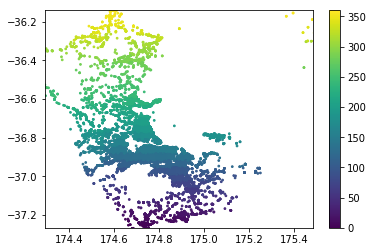

In [105]:
# verify
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# x_range = [df.longitude.min()*0.99, df.longitude.max()*1.01]
# y_range = [df.latitude.min()*0.99, df.latitude.max()*1.01]
x_range = np.percentile(df.longitude, [0.1, 99.9])
y_range = np.percentile(df.latitude, [0.1, 99.9])
img = ax.scatter(x = df['longitude'], y=df['latitude'], c = df['zone'].cat.codes, s = 3)
ax.set_xlim(x_range)
ax.set_ylim(y_range)
fig.colorbar(img, ax = ax)
plt.show()

## feature engineering - last historical value

In [24]:
# create mapping to the last historical value
last_adt_series = pd.Series(-1.0, index = df.road_name_code.unique())
def get_last_adt(row, split_date = '2017-12-31'):
    last_adt_value = last_adt_series[row['road_name_code']]
    if row['count_date'] < pd.to_datetime(split_date):
        last_adt_series.loc[row['road_name_code']] = row['adt']
    return last_adt_value

# need a separate function for test dataset

In [25]:
df['last_adt'] = df.apply(lambda row: get_last_adt(row), axis = 1)

In [109]:
# test = df[df['road_name_code'] == 2675]
# test[['count_date', 'adt', 'last_adt']]
# test.head()

,count_date,adt,last_adt
6986,2011-08-01,5385.0,-1.0
7028,2011-08-08,5400.0,5385.0
7068,2011-08-15,5497.0,5400.0
7120,2011-08-22,5579.0,5497.0
7176,2011-08-29,5388.0,5579.0
7223,2011-09-05,5599.0,5388.0
7277,2011-09-12,5333.0,5599.0
7373,2011-09-26,5500.0,5333.0
7424,2011-10-03,5752.0,5500.0
7448,2011-10-10,5283.0,5752.0


In [26]:
df.columns

Index(['count_date', 'road_name', 'adt', 'latitude', 'longitude',
       'sampling_count', 'count_Dayofweek', 'count_Dayofyear', 'count_Year',
       'count_Month', 'count_Elapsed', 'road_name_code', 'x_rotate45',
       'y_rotate45', 'lat_zone', 'long_zone', 'zone', 'last_adt'],
      dtype='object')

In [27]:
xcols = [col for col in df.columns]
cols_to_drop = ['adt', 'road_name', 'count_date']
for col in cols_to_drop:
    xcols.remove(col)
ycol = 'adt'

In [34]:
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 100, test_months = 2)
m = RandomForestRegressor(n_estimators=300, max_depth=20, max_features=0.6, oob_score= True, random_state=1, n_jobs  = 1)
m.fit(X_train, y_train)
m.score(X_train, y_train)
m.score(X_test, y_test)
m.oob_score_
rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.9069887331000408

0.6345849964247257

0.7181443107002576

,cols,imp
14,last_adt,0.293474
9,x_rotate45,0.092787
1,longitude,0.090268
7,count_Elapsed,0.088535
8,road_name_code,0.072175
0,latitude,0.070887
10,y_rotate45,0.069600
13,zone,0.063561
4,count_Dayofyear,0.056906
2,sampling_count,0.028968


## Feature generation - sampling count by road name
Noticed that 

## Feature generation - distance to tha highest adt in the zone

In [ ]:
split_date = '2018-12-31'
X_train_temp
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 100, test_months = 2)
X_train

In [139]:
xcols = [col for col in df.columns]
cols_to_drop = ['adt', 'road_name', 'count_date', 'lat_zone', 'long_zone', 'count_Year', 'count_Dayofweek', 'sampling_count', 'count_Month']
for col in cols_to_drop:
    xcols.remove(col)
ycol = 'adt'

In [140]:
X_train, X_test, y_train, y_test = split_by_forward_period(df, xcols, ycol, split_date = '2017-12-31', train_months = 24, test_months = 2)
m = RandomForestRegressor(n_estimators=500, max_depth=30, max_features=0.5, oob_score= True, random_state=1, n_jobs  = 3)
m.fit(X_train, y_train)
m.score(X_train, y_train)
m.score(X_test, y_test)
m.oob_score_
rf_feat_importance(m, X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

0.953025375489861

0.3217816779537872

0.6530644357940041

,cols,imp
8,last_adt,0.175191
5,x_rotate45,0.139545
1,longitude,0.135460
7,zone,0.098169
0,latitude,0.095467
6,y_rotate45,0.094384
4,road_name_code,0.092691
2,count_Dayofyear,0.090717
3,count_Elapsed,0.078378
